Imports

In [1]:
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import torch.optim as optim
import numpy as np
import random

In [2]:
from utils import load_protocol, plot_results
import data_utils
import audio_utils
import train_utils
from models.rawnet_modified import RawNet2BinaryClassifier

C:\Users\roee2\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Find the strongest available GPU
if torch.cuda.is_available():
    device = torch.device(f'cuda:{torch.cuda.device_count() - 1}')
elif torch.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: cuda:0


In [4]:
dataset_path = data_utils.get_data()

In [5]:
col_names = ['speaker', 'file_name', 'attack', 'label']
protocols_folder = "LA\\LA\\ASVspoof2019_LA_cm_protocols"
protocol_file_prefix = "ASVspoof2019.LA.cm"

data_info_train_file_path = f"{dataset_path}\\{protocols_folder}\\{protocol_file_prefix}.train.trn.txt"
data_info_val_file_path = f"{dataset_path}\\{protocols_folder}\\{protocol_file_prefix}.dev.trl.txt"
data_info_test_file_path = f"{dataset_path}\\{protocols_folder}\\{protocol_file_prefix}.eval.trl.txt"

In [6]:
train_df_info = load_protocol(data_info_train_file_path, names=col_names)
val_df_info = load_protocol(data_info_val_file_path, names=col_names)
test_df_info = load_protocol(data_info_test_file_path, names=col_names)

In [7]:
train_df_info['label'].value_counts()

label
spoof       22800
bonafide     2580
Name: count, dtype: int64

In [8]:
bonafide_rows = train_df_info[train_df_info['label'] == 'bonafide']
spoof_rows = train_df_info[train_df_info['label'] == 'spoof'].sample(n=len(bonafide_rows))

train_df_info = pd.concat([bonafide_rows, spoof_rows], ignore_index=True)

In [9]:
train_df_info[['label']].value_counts()


label   
bonafide    2580
spoof       2580
Name: count, dtype: int64

In [10]:
train_dir = f"{dataset_path}\\LA\\LA\\ASVspoof2019_LA_train\\flac"
val_dir = f"{dataset_path}\\LA\\LA\\ASVspoof2019_LA_dev\\flac"
test_dir = f"{dataset_path}\\LA\\LA\\ASVspoof2019_LA_eval\\flac"

In [11]:
train_df_info = audio_utils.add_augmentations(train_dir, train_df_info)

In [12]:
train_df = data_utils.process_data_frame(train_dir, train_df_info)
val_df = data_utils.process_data_frame(val_dir, val_df_info)
test_df = data_utils.process_data_frame(test_dir, test_df_info)

      file_name label
0  LA_T_1138215     0
1  LA_T_1271820     0
2  LA_T_1272637     0
3  LA_T_1276960     0
4  LA_T_1341447     0
      file_name label
0  LA_D_1047731     0
1  LA_D_1105538     0
2  LA_D_1125976     0
3  LA_D_1293230     0
4  LA_D_1340209     0
      file_name label
0  LA_E_2834763     1
1  LA_E_8877452     1
2  LA_E_6828287     1
3  LA_E_6977360     1
4  LA_E_5932896     1


In [13]:
train_df.tail()

,file_name,label
6445,aug_LA_T_1734632,1
6446,aug_LA_T_3630477,1
6447,aug_LA_T_4239283,0
6448,aug_LA_T_7165182,0
6449,aug_LA_T_1687721,1


Fit data to model

In [55]:
# class ModifiedRawNet2Model(RawNet2Model):
#     def __init__(self, pretrained=True, pretrained_path="pretrained_models_pt/rawnet2_best_weights.pt", device="cpu"):
#         super().__init__(pretrained=pretrained, class_dim=1, pretrained_path=pretrained_path, device=device, return_code=False)
#         # class_dim=1 ensures the output is a single scalar (logit)
#
#     def forward(self, x):
#         x = super().forward(x)
#         # Apply sigmoid for binary classification
#         x = torch.sigmoid(x)
#         return x

In [15]:
model = RawNet2BinaryClassifier(pretrained = True, pretrained_path="pretrained_models_pt/rawnet2_best_weights.pt", device=device)

In [14]:
def freeze_layers(model):
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze fc2_gru
    for name, module in model.named_modules():
      if 'fc2_gru' in name: # Check if it's a linear layer and its name ends with 'fc'
        print(f"Unfreesing: {name}")
        for param in module.parameters():
          param.requires_grad = True
        break # Stop after unfreezing the first matching layer

    model.to(device)

In [17]:
freeze_layers(model)

Unfreesing: encoder.fc2_gru


In [15]:
# Balance validation data to include much less data for balanced, faster training
val_bonafide_rows = val_df[val_df['label'] == 0]
val_bonafide_rows = val_bonafide_rows.sample(n=int(len(val_bonafide_rows) * 0.3))

val_spoof_rows = val_df[val_df['label'] == 1].sample(n=len(val_bonafide_rows))

val_df = pd.concat([val_bonafide_rows, val_spoof_rows], ignore_index=True)

In [16]:
val_df['label'].value_counts()

label
0    764
1    764
Name: count, dtype: int64

In [28]:
train_dataset = audio_utils.AudioDataset(train_df, data_dir=f"{dataset_path}\\LA\\LA\\ASVspoof2019_LA_train\\flac")
val_dataset = audio_utils.AudioDataset(val_df, data_dir=f"{dataset_path}\\LA\\LA\\ASVspoof2019_LA_dev\\flac")
test_dataset = audio_utils.AudioDataset(test_df, data_dir=f"{dataset_path}\\LA\\LA\\ASVspoof2019_LA_eval\\flac")

In [18]:
# clear device cache
torch.cuda.empty_cache()

In [19]:
def get_new_model_instance(device):
    model = RawNet2BinaryClassifier(pretrained = True, pretrained_path="pretrained_models_pt/rawnet2_best_weights.pt", device=device)
    freeze_layers(model)
    model.to(device)
    return model

In [20]:
seed = 42
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [27]:
results = train_utils.get_best_hyperparameters(criterion, train_dataset, val_dataset, get_new_model_instance)

Chosen device: cuda
Testing hyperparameters: {'batch_size': 64, 'epochs': 7, 'learning_rate': 0.005, 'optimizer': 'Adam'}
Unfreesing: encoder.fc2_gru
Progress of epoch 1/7: loop 0/101 finished
Progress of epoch 1/7: loop 50/101 finished
Progress of epoch 1/7: loop 100/101 finished
Epoch [1/7], Loss: 0.6776, Train Accuracy: 56.42%, Val Accuracy: 0.57%
Progress of epoch 2/7: loop 0/101 finished
Progress of epoch 2/7: loop 50/101 finished
Progress of epoch 2/7: loop 100/101 finished
Epoch [2/7], Loss: 0.6559, Train Accuracy: 63.33%, Val Accuracy: 0.63%
Progress of epoch 3/7: loop 0/101 finished
Progress of epoch 3/7: loop 50/101 finished
Progress of epoch 3/7: loop 100/101 finished
Epoch [3/7], Loss: 0.6476, Train Accuracy: 65.98%, Val Accuracy: 0.65%
Progress of epoch 4/7: loop 0/101 finished
Progress of epoch 4/7: loop 50/101 finished
Progress of epoch 4/7: loop 100/101 finished
Epoch [4/7], Loss: 0.6430, Train Accuracy: 67.22%, Val Accuracy: 0.65%
Progress of epoch 5/7: loop 0/101 fini

In [22]:
# BEST HYPER PARAMETERS
BATCH_SIZE = 64
EPOCHS = 7
LEARNING_RATE = 0.01

# Train models on best hyperparameters
criterion = nn.BCEWithLogitsLoss()
train_dataset = audio_utils.AudioDataset(train_df, data_dir=f"{dataset_path}\\LA\\LA\\ASVspoof2019_LA_train\\flac")
val_dataset = audio_utils.AudioDataset(val_df, data_dir=f"{dataset_path}\\LA\\LA\\ASVspoof2019_LA_dev\\flac")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

model = get_new_model_instance(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
results = train_utils.train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, device)

Unfreesing: encoder.fc2_gru
Progress of epoch 1/7: loop 0/101 finished
Progress of epoch 1/7: loop 50/101 finished
Progress of epoch 1/7: loop 100/101 finished
Epoch [1/7], Loss: 0.6772, Train Accuracy: 56.00%, Val Accuracy: 0.60%
Progress of epoch 2/7: loop 0/101 finished
Progress of epoch 2/7: loop 50/101 finished
Progress of epoch 2/7: loop 100/101 finished
Epoch [2/7], Loss: 0.6531, Train Accuracy: 63.26%, Val Accuracy: 0.67%
Progress of epoch 3/7: loop 0/101 finished
Progress of epoch 3/7: loop 50/101 finished
Progress of epoch 3/7: loop 100/101 finished
Epoch [3/7], Loss: 0.6435, Train Accuracy: 66.26%, Val Accuracy: 0.69%
Progress of epoch 4/7: loop 0/101 finished
Progress of epoch 4/7: loop 50/101 finished
Progress of epoch 4/7: loop 100/101 finished
Epoch [4/7], Loss: 0.6393, Train Accuracy: 67.46%, Val Accuracy: 0.70%
Progress of epoch 5/7: loop 0/101 finished
Progress of epoch 5/7: loop 50/101 finished
Progress of epoch 5/7: loop 100/101 finished
Epoch [5/7], Loss: 0.6382, T

In [24]:
last_val_accuracy, best_val_accuracy, history = results

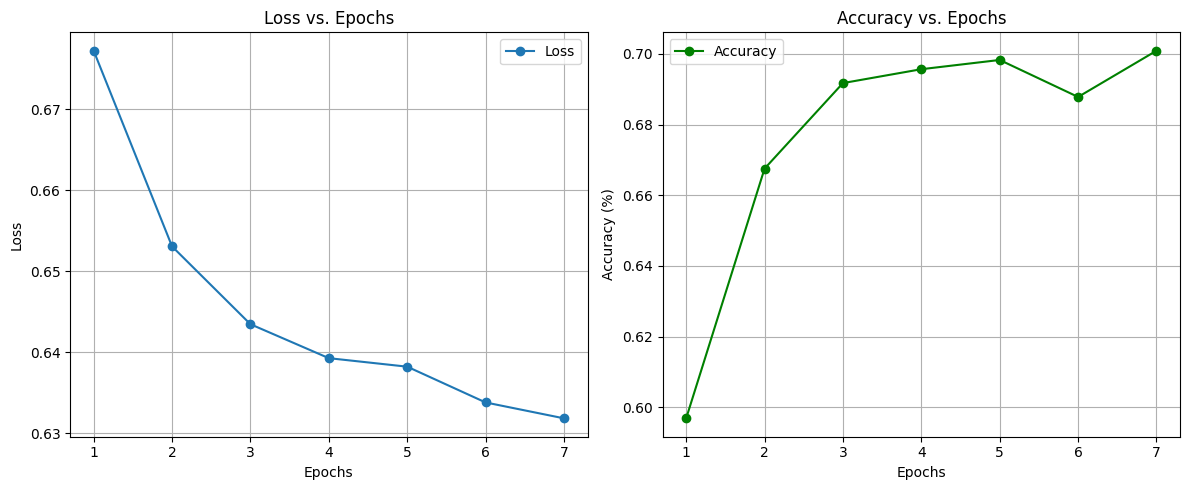

In [26]:
plot_results(history['train_loss'], history['val_accuracy'], 7)

Evaluate model on test

In [29]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [30]:
print(f"Test Results: {train_utils.evaluate_model(model, test_dataloader, criterion, device)}")

Test Results: {'loss': 0.5035756933945942, 'accuracy': 0.5991689711807067, 'precision': 0.9755545983200516, 'recall': 0.5672333364641057, 'f1': 0.7173598875536991, 'eer': 0.3305295123089631}


In [31]:
# Export to file
torch.save(model.state_dict(), "trained_models/rawnet_model_weights.pth")